In [9]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [6]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [33]:
df = pd.read_csv('Series/weekly-closings-of-the-dowjones-.csv')
series = df['Close']

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


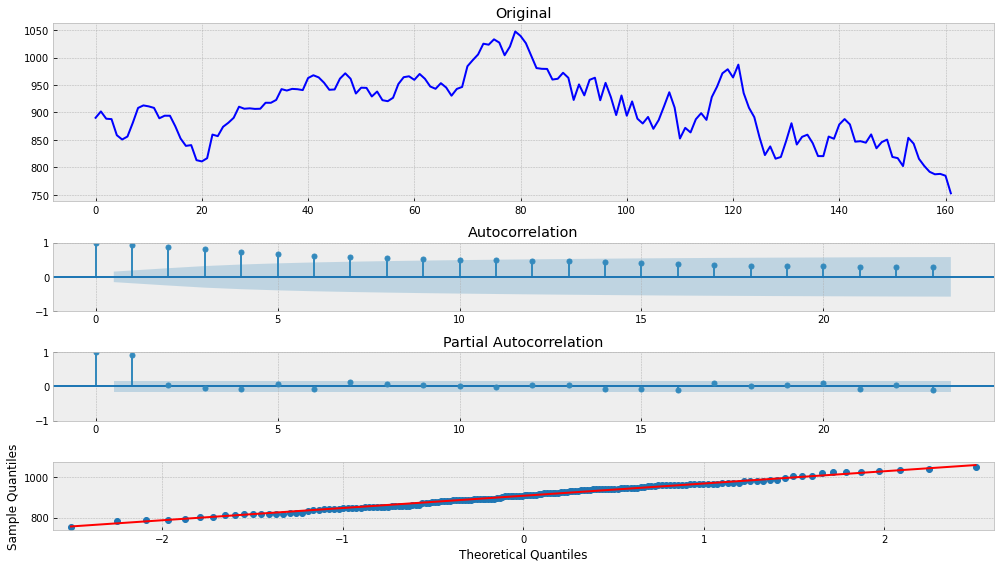

In [34]:
tsplot(series)

#### Подберем гиперпараметры ARIMA

In [35]:
def best_ARIMA_estimator(series, p=(1,5), d=(1,5), q=(1,5)):
    best_aic = np.inf
    best_order = None
    best_model = None

    for i in range(p[0], p[1]):
        for j in range(d[0], d[1]):
            for k in range(q[0], q[1]):
                model = ARIMA(series, order=(i, j, k), trend='n').fit()
                current_aic = model.aic
                print('aic: {:6.5f} | order: {}'.format(current_aic, (i, j, k)))
                if current_aic < best_aic:
                    best_aic = current_aic
                    best_order = (i, j, k)
                    best_model = model

    print('-----')
    print('best_aic: {:6.5f} | best_order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_model

In [36]:
aic, order, mdl = best_ARIMA_estimator(series)

aic: 1424.17880 | order: (1, 1, 1)
aic: 1424.40213 | order: (1, 1, 2)
aic: 1424.93317 | order: (1, 1, 3)
aic: 1425.82322 | order: (1, 1, 4)
aic: 1421.22535 | order: (1, 2, 1)
aic: 1422.48921 | order: (1, 2, 2)
aic: 1423.46868 | order: (1, 2, 3)
aic: 1423.86214 | order: (1, 2, 4)
aic: 1478.55182 | order: (1, 3, 1)
aic: 1425.79937 | order: (1, 3, 2)
aic: 1427.94402 | order: (1, 3, 3)
aic: 1429.79920 | order: (1, 3, 4)
aic: 1600.97428 | order: (1, 4, 1)
aic: 1483.33988 | order: (1, 4, 2)
aic: 1438.44630 | order: (1, 4, 3)
aic: 1440.43169 | order: (1, 4, 4)
aic: 1426.11360 | order: (2, 1, 1)
aic: 1417.25228 | order: (2, 1, 2)
aic: 1418.57747 | order: (2, 1, 3)
aic: 1426.28576 | order: (2, 1, 4)
aic: 1423.15803 | order: (2, 2, 1)
aic: 1423.20870 | order: (2, 2, 2)
aic: 1416.32751 | order: (2, 2, 3)
aic: 1417.54725 | order: (2, 2, 4)
aic: 1458.40362 | order: (2, 3, 1)
aic: 1427.70052 | order: (2, 3, 2)
aic: 1429.78699 | order: (2, 3, 3)
aic: 1423.39360 | order: (2, 3, 4)
aic: 1541.26641 | or

#### График остатков по лучшей модели

Results of Dickey-Fuller Test:
Test Statistic                 -51.719726
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


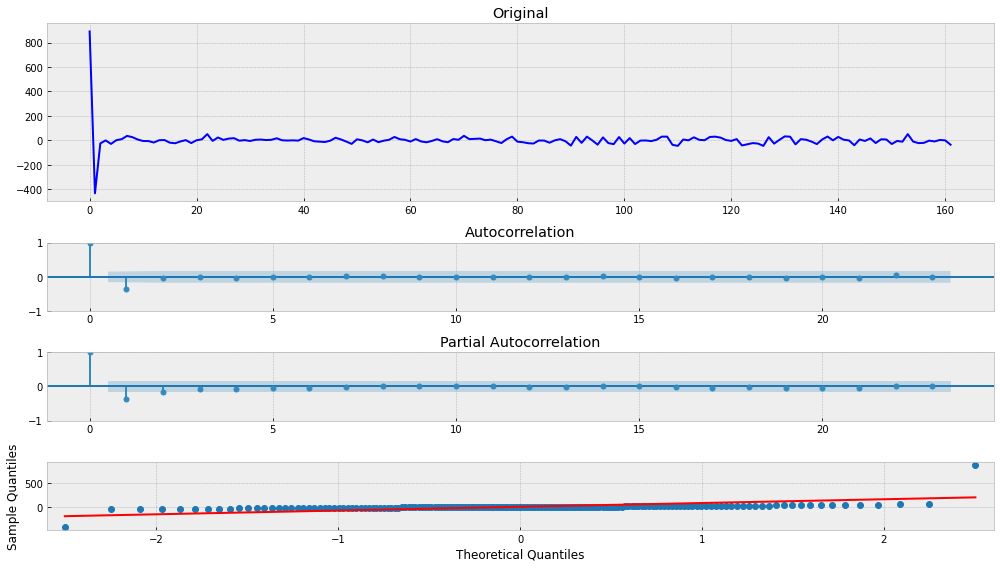

In [37]:
tsplot(mdl.resid)

#### Продифференцируем по первому порядку, уберем тренд. Сезонности нет

In [38]:
series_1 = np.diff(series, 1)

#### Обучим GARCH модель на гиперпараметрах, подобранных на ARIMA

In [65]:
p = order[0]
o = order[1]
q = order[2]

am = arch_model(series_1, p=p, o=0, q=q, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -701.663
Distribution:      Standardized Student's t   AIC:                           1419.33
Method:                  Maximum Likelihood   BIC:                           1443.98
                                              No. Observations:                  161
Date:                      Sun, Jan 16 2022   Df Residuals:                      160
Time:                              17:50:07   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

#### График остатков по дисперсии

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


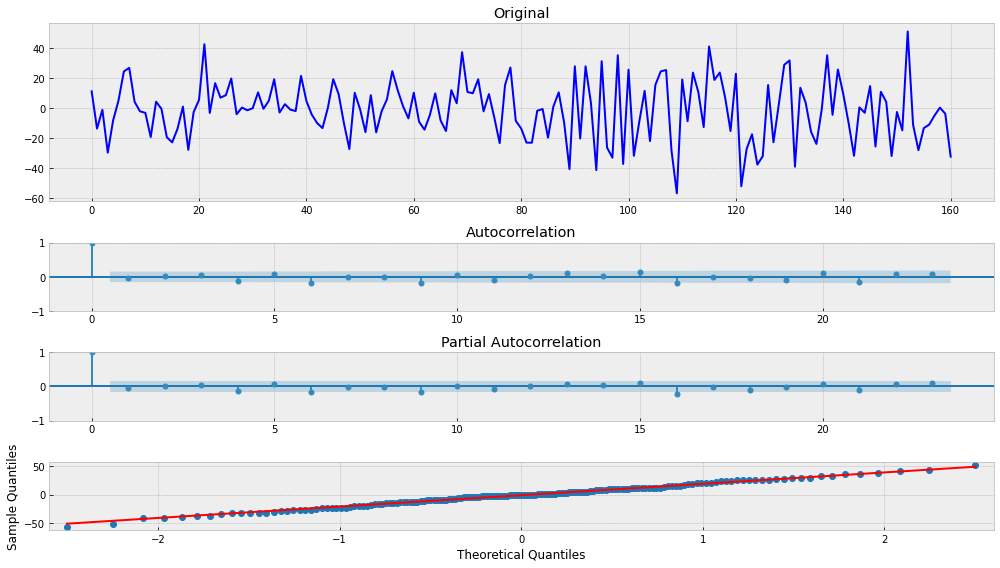

In [66]:
tsplot(res.resid)